In [ ]:
from  AISecClient import AISecClient
import os
from transformers import AutoImageProcessor, ResNetForImageClassification
from time import sleep
from datasets import load_dataset
import torch
from datetime import datetime
from art.estimators.classification import BlackBoxClassifier, KerasClassifier
from art.attacks.evasion import HopSkipJump
from art.attacks.extraction import CopycatCNN
from art.utils import to_categorical
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# setup session to use for demo
# ADD CLIENT ID AND CLIENT SECRET TO RUN NOTEBOOK
client_id = os.getenv('HIDDENLAYER_CLIENT_ID')
client_secret = os.getenv('HIDDENLAYER_CLIENT_SECRET')
client = AISecClient(client_id, client_secret)

In [ ]:
# load dataset
dataset = load_dataset("zh-plus/tiny-imagenet")
# load the microsoft/resnet-50 model
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
sensor = client.get_sensor_by_name_version("microsoft/resnet-50", 1)

In [ ]:
test_image = dataset["valid"]["image"][3]
display(test_image)

In [ ]:
def process_array(input_array, low, high):
    # Ensure the input is a numpy array
    input_array = np.asarray(input_array)

    # Generate a random matrix of the same shape
    random_matrix = np.random.uniform(low=low, high=high, size=input_array.shape)

    # Multiply the input array by the random matrix
    multiplied_array = input_array * random_matrix

    # Normalize the multiplied array back to the range 0.0 to 255.0
    min_val = multiplied_array.min()
    max_val = multiplied_array.max()
    normalized_array = 255 * (multiplied_array - min_val) / (max_val - min_val)
    normalized_array = normalized_array.astype(np.uint8)
    return normalized_array

In [ ]:
%%time
image_array = np.array(test_image)
pimg = processor(image_array, return_tensors="pt")
low = 0.9
high = 1.1
with torch.no_grad():
    for i in range(20):
        image_array = process_array(image_array, low, high) 
        t = processor(image_array, return_tensors="pt")['pixel_values']
        p = model(t.float())
        prob = p.logits
        l = prob.argmax(-1).item()
        tl = model.config.id2label[l]
        print (i, l,tl)
        client.submit_to_mldr(sensor["sensor_id"], "resnet-50-demo", pimg["pixel_values"].numpy(),
                              p.logits.numpy(), predictions=[l])

        low *= 0.995
        high *= 1.005
        plt.imshow(image_array)
        plt.show()

In [23]:
tl

'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus'

In [ ]:
Total Inferences 7084; Severity 4301
Total Inferences 7094; Severity 4301

1 goldfish, Carassius auratus tensor(10.2233)
1 goldfish, Carassius auratus tensor(8.7789)
1 goldfish, Carassius auratus tensor(7.6836)
1 goldfish, Carassius auratus tensor(7.8926)
1 goldfish, Carassius auratus tensor(7.3359)
1 goldfish, Carassius auratus tensor(6.9145)
1 goldfish, Carassius auratus tensor(6.4286)
1 goldfish, Carassius auratus tensor(6.7729)
1 goldfish, Carassius auratus tensor(5.9692)
1 goldfish, Carassius auratus tensor(3.9773)
1 goldfish, Carassius auratus tensor(3.3998)
1 goldfish, Carassius auratus tensor(2.2680)
1 goldfish, Carassius auratus tensor(1.3577)
1 goldfish, Carassius auratus tensor(0.9739)
1 goldfish, Carassius auratus tensor(1.3684)
1 goldfish, Carassius auratus tensor(0.7256)
1 goldfish, Carassius auratus tensor(0.4242)
1 goldfish, Carassius auratus tensor(0.1503)
1 goldfish, Carassius auratus tensor(-0.7901)
1 goldfish, Carassius auratus tensor(-1.1057)
1 goldfish, Carassius auratus tensor(-0.8915)
103 platypus, duckbill, duckbilled platypus, duck-b

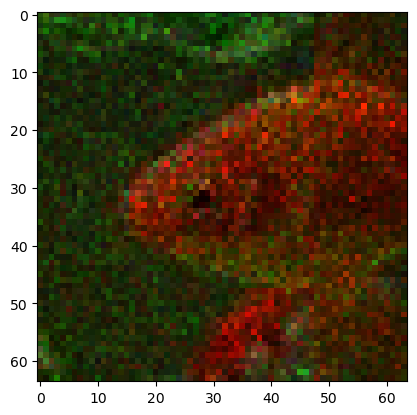

In [39]:
image_array = np.array(test_image)
pimg = processor(image_array, return_tensors="pt")
low = 0.9
high = 1.1
with torch.no_grad():
    for _ in range(10000):
        image_array = process_array(image_array, low, high) 
        t = processor(image_array, return_tensors="pt")['pixel_values']
        p = model(t.float())
        prob = p.logits
        l = prob.argmax(-1).item()
        tl = model.config.id2label[l]
        print (l,tl, prob[0][l])
        client.submit_to_mldr(sensor["sensor_id"], "resnet-50-demo", pimg["pixel_values"].numpy(),
                              p.logits.numpy(), predictions=[l])

        low *= 0.999
        high *= 1.001
        if tl != 'goldfish, Carassius auratus':
            plt.imshow(image_array)
            plt.show()
            break

In [38]:
low

0.8821699783465812

In [ ]:
image_array = np.array(test_image)
pimg = processor(image_array, return_tensors="pt")
low = 0.9
high = 1.1
with torch.no_grad():
    for _ in range(10000):
        image_array = process_array(image_array, low, high) 
        t = processor(image_array, return_tensors="pt")['pixel_values']
        p = model(t.float())
        prob = p.logits
        l = prob.argmax(-1).item()
        tl = model.config.id2label[l]
        print (l,tl)
#        client.submit_to_mldr(sensor["sensor_id"], "resnet-50-demo", pimg["pixel_values"].numpy(),
#                              p.logits.numpy(), predictions=[l])

        low *= 0.995
        high *= 1.002
        if tl != 'goldfish, Carassius auratus':
            plt.imshow(image_array)
            plt.show()
            break

In [32]:
prob[0][l]

tensor(-1.6380)